In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

In [4]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=448, grid_size=14, num_bboxes=1,max_images=None,transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.grid_size = grid_size
        self.num_bboxes = num_bboxes
        self.transform = transform
        self.img_files = []
        count = 0
        for img_file in os.listdir(img_dir):
            if img_file.endswith('.jpg'):
                self.img_files.append(img_file)
                count += 1
                if max_images is not None and count >= max_images:
                    break

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.img_size, self.img_size))

        if self.transform:
            img = self.transform(img)

        label_path = os.path.join(self.label_dir, self.img_files[idx].replace('.jpg', '.txt'))
        boxes = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file:
                    _, x_center, y_center, width, height = map(float, line.strip().split())
                    boxes.append([x_center, y_center, width, height, 1.0])

        target_grid = self.map_targets_to_grid(boxes, self.grid_size, self.num_bboxes)

        return img, target_grid

    def map_targets_to_grid(self, targets, grid_size, num_bboxes):
        target_grid = torch.zeros((grid_size, grid_size, num_bboxes * 5))

        for i in range(grid_size):
           for j in range(grid_size):
                x_center = (j + 0.5) / grid_size
                y_center = (i + 0.5) / grid_size
                target_grid[i, j, :4] = torch.tensor([x_center, y_center, 0.0, 0.0])
                target_grid[i, j, 4] = 0.0

        for target in targets:
            x_center, y_center, width, height, conf = target

            grid_x = int(x_center * grid_size)
            grid_y = int(y_center * grid_size)

            bbox_index = 0
            target_grid[grid_y, grid_x, bbox_index * 5:bbox_index * 5 + 4] = torch.tensor([x_center, y_center, width, height])
            target_grid[grid_y, grid_x, bbox_index * 5 + 4] = conf

        return target_grid

In [5]:
img_dir_train='/content/drive/My Drive/YoloData/images/train'
label_dir_train='/content/drive/My Drive/YoloData/labels/train'
img_dir_test='/content/drive/My Drive/YoloData/images/val'
label_dir_test='/content/drive/My Drive/YoloData/labels/val'

data_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_val_dataset = FaceDataset(
    img_dir=img_dir_train,
    label_dir=label_dir_train,
    transform=data_transforms,
    max_images=5000
)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

test_dataset = FaceDataset(
    img_dir=img_dir_test,
    label_dir=label_dir_test,
    transform=data_transforms,
    max_images=1000
)

In [6]:
def collate_fn(batch):
    images, targets = zip(*batch)

    images = torch.stack(images, dim=0)

    return images, targets

In [7]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset,batch_size=8,shuffle=True,num_workers=2,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2,collate_fn=collate_fn)

In [8]:
import torch
import torch.nn as nn
import numpy as np

In [9]:
class YOLO(nn.Module):
  def __init__(self,grid_size=14,num_bboxes=1):
    super(YOLO,self).__init__()
    self.grid_size=grid_size
    self.num_bboxes=num_bboxes
    self.num_classes=1

    self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),

            nn.Conv2d(256, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2) #14x14x512
        )

    self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * self.grid_size * self.grid_size, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.grid_size * self.grid_size * (self.num_bboxes * 5))
        )

  def forward(self, x):

        x = self.conv_layers(x)
        x = self.fc_layers(x)

        x = x.view(-1, self.grid_size, self.grid_size, self.num_bboxes * 5)

        bboxes = torch.sigmoid(x[..., :self.num_bboxes * 5])

        return bboxes
  def predict(self, x, iou_threshold=0.5, confidence_threshold=0.5):
        bboxes = self.forward(x)

        filtered_boxes = []
        filtered_scores = []


        for i in range(self.grid_size):
            for j in range(self.grid_size):
                for b in range(self.num_bboxes):
                    offset = b * 5
                    confidence = bboxes[:, i, j, offset + 4]
                    if confidence > confidence_threshold:
                        box = bboxes[:, i, j, offset:offset + 4]
                        score = confidence
                        filtered_boxes.append(box)
                        filtered_scores.append(score)


        if len(filtered_boxes) == 0:
            return [], []

        filtered_boxes = torch.stack(filtered_boxes)
        filtered_scores = torch.stack(filtered_scores)


        keep_indices = nms(filtered_boxes, filtered_scores, iou_threshold)
        final_boxes = filtered_boxes[keep_indices]
        final_scores = filtered_scores[keep_indices]


        return final_boxes, final_scores


In [10]:
def xywh_to_xyxy(box):
    x_center, y_center, width, height = box[:4]
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)
    return torch.tensor([x_min, y_min, x_max, y_max])

In [11]:
def iou(box1, box2):
    box1 = xywh_to_xyxy(box1)
    box2 = torch.stack([xywh_to_xyxy(b) for b in box2])

    inter_x_min = torch.max(box1[0], box2[:, 0])
    inter_y_min = torch.max(box1[1], box2[:, 1])
    inter_x_max = torch.min(box1[2], box2[:, 2])
    inter_y_max = torch.min(box1[3], box2[:, 3])

    inter_area = torch.clamp(inter_x_max - inter_x_min, min=0) * torch.clamp(inter_y_max - inter_y_min, min=0)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    iou = inter_area / (area1 + area2 - inter_area)
    return iou

In [12]:
def nms(bboxes, scores, iou_threshold=0.5):
    keep = []
    indices = scores.sort(descending=True)[1]

    while indices.numel() > 0:
        current = indices[0]
        keep.append(current.item())
        if indices.numel() == 1:
            break

        ious = iou(bboxes[current], bboxes[indices[1:]])
        indices = indices[1:][ious < iou_threshold]

    return keep

In [13]:
model = YOLO()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

YOLO(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_s

In [14]:
import torch.optim as optim

In [15]:
import torch

def yolo_loss(pred_bboxes, target, lambda_coord=5,lambda_size=3,lambda_obj=10, lambda_noobj=1):
    obj_mask = target[..., 4] > 0
    noobj_mask = target[..., 4] == 0

    coord_center_loss = lambda_coord * torch.sum((pred_bboxes[obj_mask][..., :2] - target[obj_mask][..., :2]) ** 2)
    coord_size_loss = lambda_size * torch.sum((pred_bboxes[obj_mask][..., 2:4] - target[obj_mask][..., 2:4]) ** 2)

    obj_loss = lambda_obj*torch.sum((pred_bboxes[obj_mask][..., 4] - target[obj_mask][..., 4]) ** 2)
    noobj_loss = lambda_noobj * torch.sum(pred_bboxes[noobj_mask][..., 4] ** 2)
    #noobj_loss_1 = lambda_noobj * torch.sum(torch.clamp(pred_bboxes[noobj_mask_1][..., 4], min=1e-6) ** 2)

    loss = coord_center_loss + coord_size_loss + obj_loss + noobj_loss
    return loss


In [16]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001,checkpoint_dir='/content/drive/My Drive/checkpoints',patience=5):
    training_losses = []
    validation_losses = []
    best_val_loss = np.inf
    epochs_no_improve = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

        for images, targets in progress_bar:
            images = images.to(device)

            targets = [target.to(device) for target in targets]

            optimizer.zero_grad()

            bboxes = model(images) #(8,14,14,5)

            losses = [yolo_loss(bbox, target) for bbox, target in zip(bboxes, targets)]
            loss = torch.mean(torch.stack(losses))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})

        avg_loss = running_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

        scheduler.step()

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_targets in val_loader:
                val_images = val_images.to(device)
                val_targets = [val_target.to(device) for val_target in val_targets]

                val_bboxes = model(val_images)
                val_losses = [yolo_loss(val_bbox, val_target) for val_bbox, val_target in zip(val_bboxes, val_targets)]
                val_loss = torch.mean(torch.stack(val_losses))

                val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss}")

        save_checkpoint(model, optimizer, epoch + 1, avg_loss, checkpoint_dir)
        model.train()

    print("Training complete!")
    return training_losses,validation_losses


In [17]:
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir="checkpoints"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}_loss_{loss:.4f}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

In [18]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded checkpoint '{checkpoint_path}' (epoch {epoch}, loss {loss})")
    return epoch, loss

In [19]:
train_model(model,train_loader,val_loader,num_epochs=30)

Epoch [1/30]: 100%|██████████| 500/500 [26:20<00:00,  3.16s/it, Loss=25.7]

Epoch [1/30], Loss: 43.95612961769104


Epoch [1/30], Validation Loss: 45.31592042541504
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_1_loss_43.9561.pth


Epoch [2/30]: 100%|██████████| 500/500 [03:16<00:00,  2.55it/s, Loss=59.1]

Epoch [2/30], Loss: 42.07585417175293


Epoch [2/30], Validation Loss: 44.81557389831543
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_2_loss_42.0759.pth


Epoch [3/30]: 100%|██████████| 500/500 [05:21<00:00,  1.56it/s, Loss=76.2]

Epoch [3/30], Loss: 41.76775754165649


Epoch [3/30], Validation Loss: 45.02177584838867
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_3_loss_41.7678.pth


Epoch [4/30]: 100%|██████████| 500/500 [05:33<00:00,  1.50it/s, Loss=24.8]

Epoch [4/30], Loss: 41.68432235145569


Epoch [4/30], Validation Loss: 44.465213241577146
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_4_loss_41.6843.pth


Epoch [5/30]: 100%|██████████| 500/500 [03:14<00:00,  2.58it/s, Loss=16]

Epoch [5/30], Loss: 41.7476360282898


Epoch [5/30], Validation Loss: 44.710442993164065
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_5_loss_41.7476.pth


Epoch [6/30]: 100%|██████████| 500/500 [13:41<00:00,  1.64s/it, Loss=54.6]

Epoch [6/30], Loss: 41.56403115081787


Epoch [6/30], Validation Loss: 44.49037738037109
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_6_loss_41.5640.pth


Epoch [7/30]: 100%|██████████| 500/500 [04:26<00:00,  1.88it/s, Loss=28.2]

Epoch [7/30], Loss: 41.43172689628601


Epoch [7/30], Validation Loss: 45.10099528503418
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_7_loss_41.4317.pth


Epoch [8/30]: 100%|██████████| 500/500 [03:27<00:00,  2.41it/s, Loss=45.2]

Epoch [8/30], Loss: 40.53510946083069


Epoch [8/30], Validation Loss: 43.038384872436524
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_8_loss_40.5351.pth


Epoch [9/30]: 100%|██████████| 500/500 [06:25<00:00,  1.30it/s, Loss=55.7]

Epoch [9/30], Loss: 39.9389230594635


Epoch [9/30], Validation Loss: 42.87798335266113
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_9_loss_39.9389.pth


Epoch [10/30]: 100%|██████████| 500/500 [04:31<00:00,  1.84it/s, Loss=25.2]

Epoch [10/30], Loss: 39.962927619934085


Epoch [10/30], Validation Loss: 43.08964167785645
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_10_loss_39.9629.pth


Epoch [11/30]: 100%|██████████| 500/500 [06:07<00:00,  1.36it/s, Loss=62.1]

Epoch [11/30], Loss: 39.98172257232666


Epoch [11/30], Validation Loss: 42.97114181518555
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_11_loss_39.9817.pth


Epoch [12/30]: 100%|██████████| 500/500 [06:24<00:00,  1.30it/s, Loss=28.7]

Epoch [12/30], Loss: 39.93109414291382


Epoch [12/30], Validation Loss: 42.96285592651367
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_12_loss_39.9311.pth


Epoch [13/30]: 100%|██████████| 500/500 [04:32<00:00,  1.84it/s, Loss=19.7]

Epoch [13/30], Loss: 39.87772870635986


Epoch [13/30], Validation Loss: 42.93415267944336
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_13_loss_39.8777.pth


Epoch [14/30]: 100%|██████████| 500/500 [06:42<00:00,  1.24it/s, Loss=35.7]

Epoch [14/30], Loss: 39.77312410736084


Epoch [14/30], Validation Loss: 42.57352548980713
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_14_loss_39.7731.pth


Epoch [15/30]: 100%|██████████| 500/500 [04:21<00:00,  1.92it/s, Loss=20.3]

Epoch [15/30], Loss: 39.512195236206054


Epoch [15/30], Validation Loss: 42.596894668579104
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_15_loss_39.5122.pth


Epoch [16/30]: 100%|██████████| 500/500 [03:15<00:00,  2.56it/s, Loss=40.5]

Epoch [16/30], Loss: 39.814220016479496


Epoch [16/30], Validation Loss: 43.022571029663084
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_16_loss_39.8142.pth


Epoch [17/30]: 100%|██████████| 500/500 [06:19<00:00,  1.32it/s, Loss=27.3]

Epoch [17/30], Loss: 39.99341291809082


Epoch [17/30], Validation Loss: 43.06196263122558
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_17_loss_39.9934.pth


Epoch [18/30]: 100%|██████████| 500/500 [05:18<00:00,  1.57it/s, Loss=44.7]

Epoch [18/30], Loss: 39.87372979736328


Epoch [18/30], Validation Loss: 43.01303540039063
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_18_loss_39.8737.pth


Epoch [19/30]: 100%|██████████| 500/500 [03:14<00:00,  2.57it/s, Loss=54]

Epoch [19/30], Loss: 40.058445259094235


Epoch [19/30], Validation Loss: 43.368900115966795
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_19_loss_40.0584.pth


Epoch [20/30]: 100%|██████████| 500/500 [07:11<00:00,  1.16it/s, Loss=28]

Epoch [20/30], Loss: 40.04457963562012


Epoch [20/30], Validation Loss: 43.30929903411865
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_20_loss_40.0446.pth


Epoch [21/30]: 100%|██████████| 500/500 [04:17<00:00,  1.94it/s, Loss=44.9]

Epoch [21/30], Loss: 40.169150787353516


Epoch [21/30], Validation Loss: 43.197659759521486
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_21_loss_40.1692.pth


Epoch [22/30]: 100%|██████████| 500/500 [06:31<00:00,  1.28it/s, Loss=22.9]

Epoch [22/30], Loss: 40.04669909095764


Epoch [22/30], Validation Loss: 43.09702746582031
Checkpoint saved at /content/drive/My Drive/checkpoints/model_epoch_22_loss_40.0467.pth


Epoch [23/30]:   1%|▏         | 7/500 [00:08<10:22,  1.26s/it, Loss=59.3]


KeyboardInterrupt: 

In [22]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def predict_and_draw(model, test_loader, device):
    model.eval()

    data_iter = iter(test_loader)
    next(data_iter)
    next(data_iter)
    next(data_iter)
    next(data_iter)
    next(data_iter)
    images, targets = next(data_iter)
    image = images[0].unsqueeze(0).to(device)
    print("Image size:",image.shape)

    with torch.no_grad():
        predictions = model(image)

    predictions = predictions[0].cpu().numpy()

    img = images[0].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    ax = plt.gca()

    grid_size = 14
    num_bboxes = 1

    for i in range(grid_size):
        for j in range(grid_size):
            #confidence = predictions[i, j, 4]
            #if confidence > 0:
                x_center, y_center, width, height = predictions[i, j, :4]


                x_center = (x_center + j) / grid_size
                y_center = (y_center + i) / grid_size
                width /= grid_size
                height /= grid_size


                xmin = x_center - width / 2
                ymin = y_center - height / 2
                xmax = x_center + width / 2
                ymax = y_center + height / 2


                xmin *= img.shape[1]
                xmax *= img.shape[1]
                ymin *= img.shape[0]
                ymax *= img.shape[0]


                rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='red')
                ax.add_patch(rect)

    plt.axis('off')
    plt.show()


Image size: torch.Size([1, 3, 448, 448])


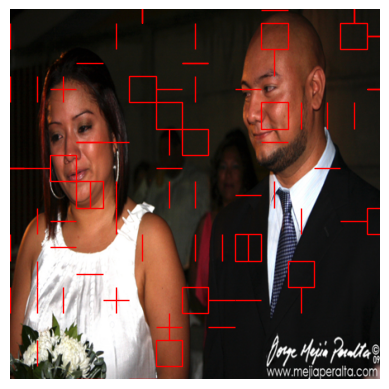

In [23]:
predict_and_draw(model, test_loader, device)